In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import plots # Custom functions for plotting

# Tricking your cerebellum
## Task 3: Feedback

By: Ieva Kerseviciute* and Robin Uhrich*

*equal contribution

## Task 1: Implementation of feedback_types



## Task 2: Analysis of feedback on unbiased subjects

For this task, we recorded data from two unbiased subjects. We are including some of their comments while performing the task:

- Subject 1:
    - The line between failure and perfection in this game is very thin 
    - In life, sometimes it's better not to know (during the blocks with masked trajectory)

- Subject 2:
    - If the eye cannot see, the heart cannot hurt (during the blocks with masked trajectory)
    - This is making me anxious, I don't see it, and then it's like a surprise (during the blocks with masked trajectory)
    - I hate it, my brain says to my hand to go fast and my hand doesn't (noticing that they are constantly undershooting)

In [2]:
# Read subject data
experiment, full_experiment = plots.define_experiment()

subject1 = pd.read_csv("Subject_1.csv")
subject1 = pd.merge(subject1, full_experiment, on = "Trial")

subject2 = pd.read_csv("Subject_2.csv")
subject2 = pd.merge(subject2, full_experiment, on = "Trial")

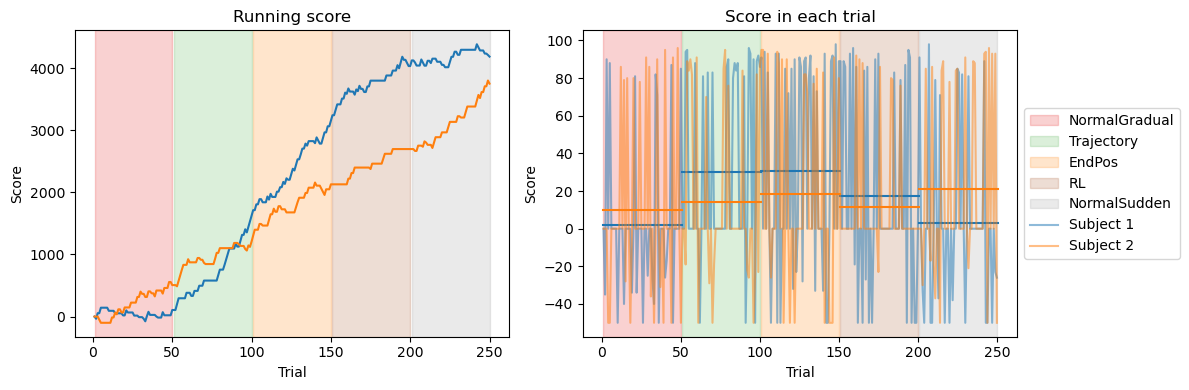

In [3]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 4))
plots.plot_running_score(experiment, subjects = [subject1, subject2], ax = axs[0], show_legend = False)
plots.plot_trial_score(experiment, subjects = [subject1, subject2], ax = axs[1])
fig.tight_layout()

**Figure 1.** (Left) The running score across the experiment and (right) the score for each trial, with vertical lines representing the mean score for each block, for subjects 1 and 2. The different experimental blocks are visually highlighted. Subject 2 demonstrates a steady improvement in task performance throughout the experiment, while subject 1 shows a significant decline in performance during the final block, despite the movement of the pint being visible. Subject 1 reported that performing the task was easier when the movement of the pint was not revealed, as in the "Trajectory", "EndPos", and "RL" blocks. Conversely, subject 2 found the "RL" block to be the most challenging.

### Subject 1

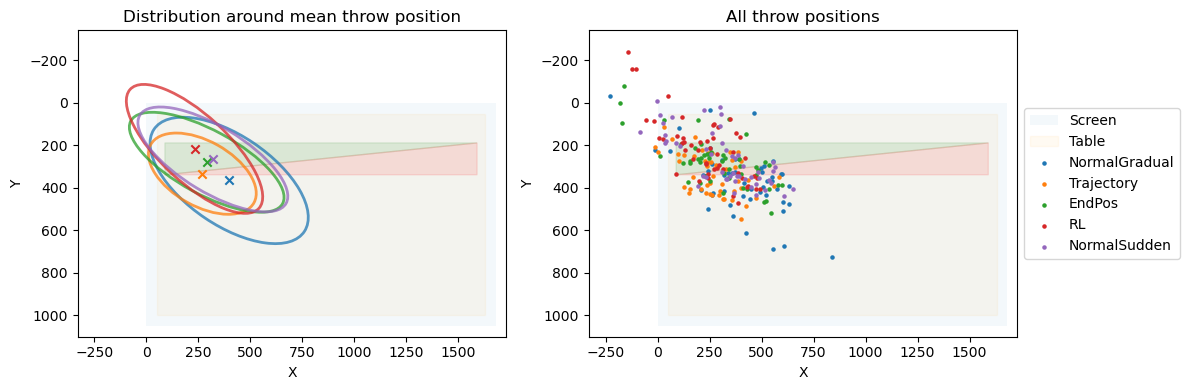

In [4]:
plots.plot_throw_positions(subject1)

**Figure 2.1.**

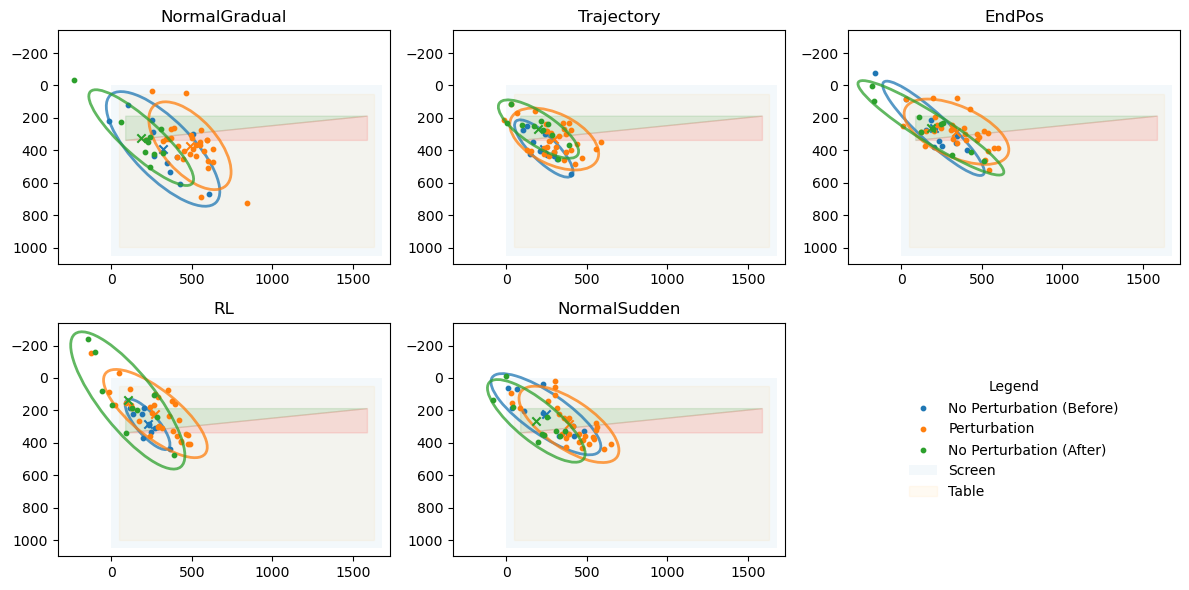

In [5]:
plots.plot_throw_perturbation(subject1)

**Figure 2.2.**

### Subject 2

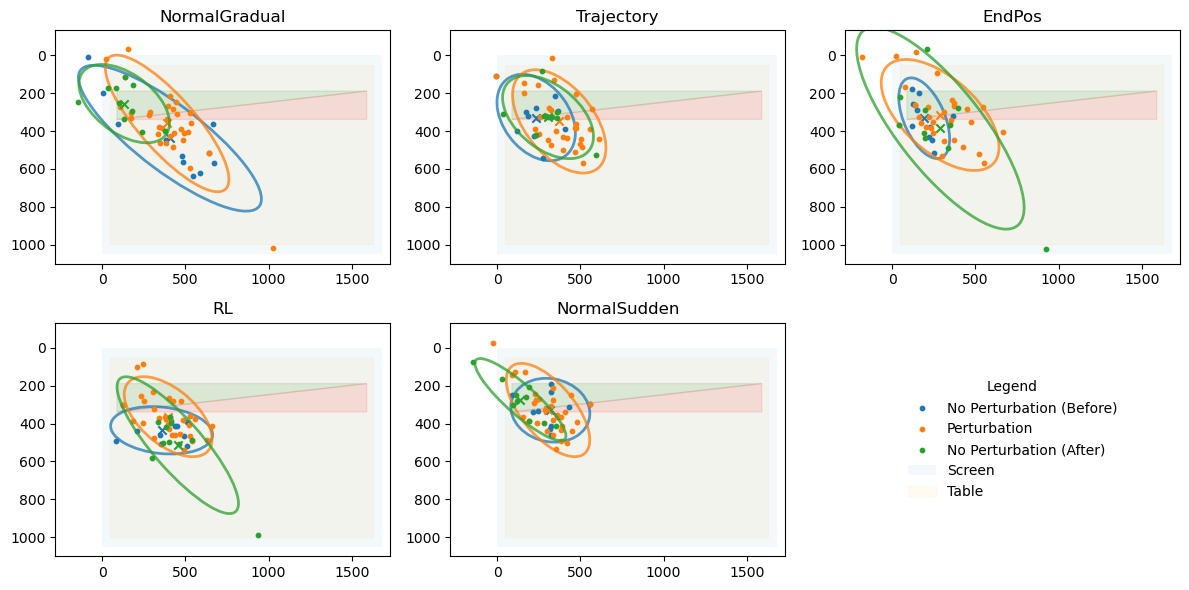

In [6]:
plots.plot_throw_perturbation(subject2)

**Figure 3.1.**

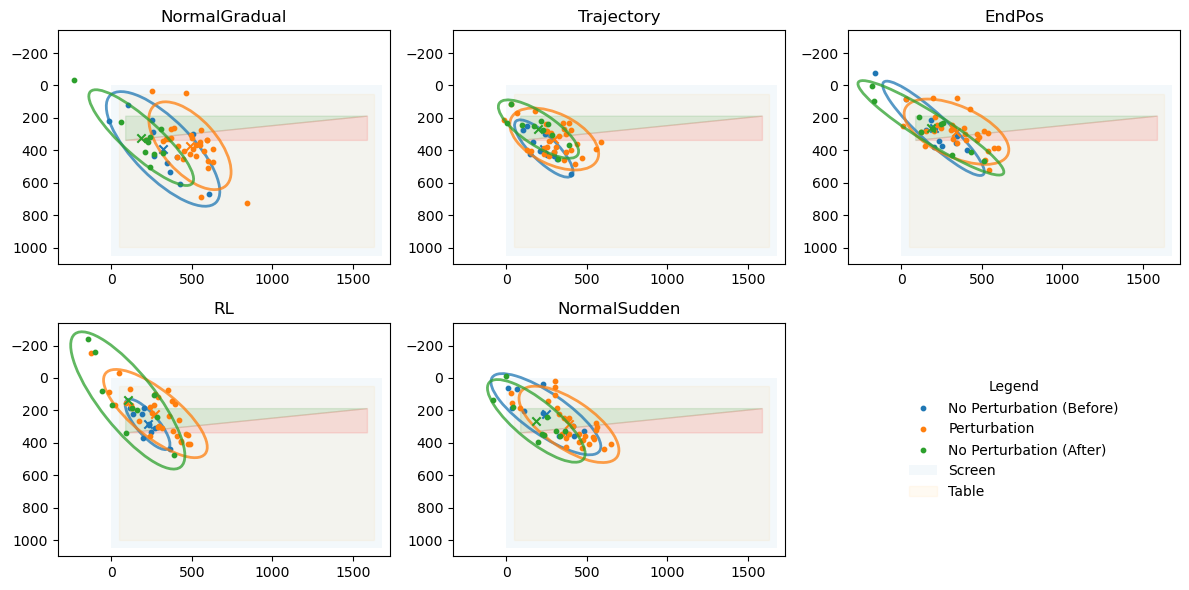

In [7]:
plots.plot_throw_perturbation(subject1)

**Figure 3.2.**